# Goal 1:
## My parameter: number of categories
### Approach:

- start with 2 categories
- add more categories per run and save results until 5 different "number of categories" were tested

### Assumption:

- the more categories, the more time to predict
- more categories --> less accuracy

In [9]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import time

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'dislike', 'stop', 'rock', 'ok', 'one', 'three', 'two_up', 'fist', 'peace'] #'ok', 'one', 'three', 'two_up', 'fist', 'peace'

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

## helper function to load and parse annotations

In [10]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

## helper function to pre-process images (color channel conversion and resizing)

In [11]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

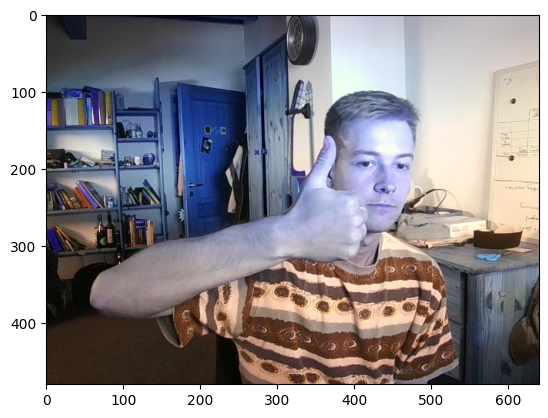

In [18]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if COLOR_CHANNELS == 1:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
cap.release()
plt.imshow(frame)

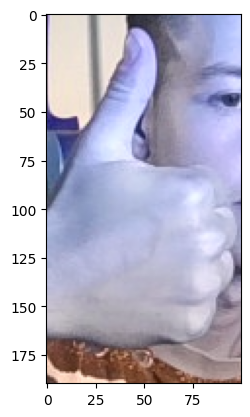

In [23]:
plt.imshow(frame[150:340,320:420])

(64, 64, 3)

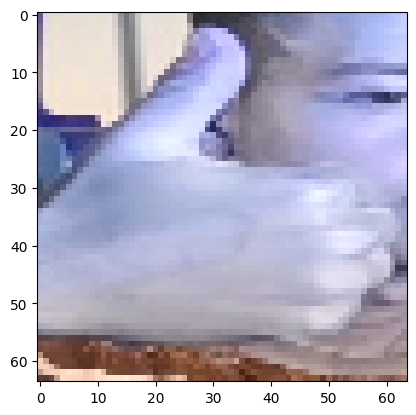

In [25]:
resized = cv2.resize(frame[150:340,320:420], SIZE)
plt.imshow(resized)
resized.shape

In [26]:
reshaped = resized.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
reshaped.shape

(1, 64, 64, 3)

## load images and annotations

In [27]:
eval_array = []
predict_durations = []
# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for num_conditions in range(2, len(CONDITIONS) + 1):
    images = [] # stores actual image data
    labels = [] # stores labels (as integer - because this is what our network needs)
    label_names = [] # maps label ints to their actual categories so we can understand predictions later

    for condition in CONDITIONS[:num_conditions]:
        for filename in tqdm(os.listdir(condition)):
            # extract unique ID from file name
            UID = filename.split('.')[0]
            img = cv2.imread(f'{condition}/{filename}')
            
            # get annotation from the dict we loaded earlier
            try:
                annotation = annotations[condition][UID]
            except Exception as e:
                print(e)
                continue
            
            # iterate over all hands annotated in the image
            for i, bbox in enumerate(annotation['bboxes']):
                # annotated bounding boxes are in the range from 0 to 1
                # therefore we have to scale them to the image size
                x1 = int(bbox[0] * img.shape[1])
                y1 = int(bbox[1] * img.shape[0])
                w = int(bbox[2] * img.shape[1])
                h = int(bbox[3] * img.shape[0])
                x2 = x1 + w
                y2 = y1 + h
                
                # crop image to the bounding box and apply pre-processing
                crop = img[y1:y2, x1:x2]
                preprocessed = preprocess_image(crop)
                
                # get the annotated hand's label
                # if we have not seen this label yet, add it to the list of labels
                label = annotation['labels'][i]
                if label not in label_names:
                    label_names.append(label)
                
                label_index = label_names.index(label)
                
                images.append(preprocessed)
                labels.append(label_index)
                
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    X_train = np.array(X_train).astype('float32')
    X_train = X_train / 255.

    X_test = np.array(X_test).astype('float32')
    X_test = X_test / 255.

    y_train_one_hot = to_categorical(y_train)
    y_test_one_hot = to_categorical(y_test)

    train_label = y_train_one_hot
    test_label = y_test_one_hot

    X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
    X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

    # variables for hyperparameters
    batch_size = 8
    epochs = 50
    num_classes = len(label_names)
    activation = 'relu'
    activation_conv = 'LeakyReLU'  # LeakyReLU
    layer_count = 2
    num_neurons = 64

    # define model structure
    # with keras, we can use a model's add() function to add layers to the network one by one
    model = Sequential()

    # data augmentation (this can also be done beforehand - but don't augment the test dataset!)
    model.add(RandomFlip('horizontal'))
    model.add(RandomContrast(0.1))
    #model.add(RandomBrightness(0.1))
    #model.add(RandomRotation(0.2))

    # first, we add some convolution layers followed by max pooling
    model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

    model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

    model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # dropout layers can drop part of the data during each epoch - this prevents overfitting
    model.add(Dropout(0.2))

    # after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
    model.add(Flatten())

    # add some fully connected layers ("Dense")
    for i in range(layer_count - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(num_neurons, activation=activation))

    # for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
    model.add(Dense(num_classes, activation='softmax'))

    # specify loss function, optimizer and evaluation metrics
    # for classification, categorial crossentropy is used as a loss function
    # use the adam optimizer unless you have a good reason not to
    model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

    # define callback functions that react to the model's behavior during training
    # in this example, we reduce the learning rate once we get stuck and early stopping
    # to cancel the training if there are no improvements for a certain amount of epochs
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)

    start_time = time.time()

    history = model.fit(
        X_train,
        train_label,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, test_label),
        callbacks=[reduce_lr, stop_early]
    )

    end_time = time.time()
    duration = end_time - start_time
    eval = model.evaluate(X_test, test_label)
    eval.append(num_classes)
    eval.append(duration)
    eval_array.append(eval)

    start_predict_time = time.time()
    prediction = model.predict(reshaped) # prediction based on input img
    end_predict_time = time.time()
    predict_duration = []
    predict_duration.append(end_predict_time - start_predict_time)
    predict_duration.append(num_classes)
    predict_durations.append(predict_duration)


    


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50
65/65 [==============================] - 3s 34ms/step - loss: 1.0639 - accuracy: 0.4324 - val_loss: 0.9664 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 2s 31ms/step - loss: 0.9064 - accuracy: 0.5772 - val_loss: 0.6072 - val_accuracy: 0.7923 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 2s 31ms/step - loss: 0.6203 - accuracy: 0.7201 - val_loss: 0.3949 - val_accuracy: 0.8538 - lr: 0.0010
Epoch 4/50
65/65 [==============================] - 2s 31ms/step - loss: 0.4696 - accuracy: 0.8166 - val_loss: 0.4690 - val_accuracy: 0.7846 - lr: 0.0010
Epoch 5/50
65/65 [==============================] - 2s 31ms/step - loss: 0.3663 - accuracy: 0.8514 - val_loss: 0.2268 - val_accuracy: 0.9308 - lr: 0.0010
Epoch 6/50
65/65 [==============================] - 2s 31ms/step - loss: 0.3009 - accuracy: 0.8822 - val_loss: 0.2876 - val_accuracy: 0.8769 - lr: 0.0010
Epoch 7/50
65/65 [==============================] - 2s 31ms/step - loss: 0.2

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50
97/97 [==============================] - 4s 33ms/step - loss: 1.4021 - accuracy: 0.2796 - val_loss: 1.3546 - val_accuracy: 0.3231 - lr: 0.0010
Epoch 2/50
97/97 [==============================] - 3s 31ms/step - loss: 1.3926 - accuracy: 0.3054 - val_loss: 1.3361 - val_accuracy: 0.3026 - lr: 0.0010
Epoch 3/50
97/97 [==============================] - 3s 31ms/step - loss: 1.3136 - accuracy: 0.3518 - val_loss: 1.1704 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 4/50
97/97 [==============================] - 3s 31ms/step - loss: 1.0298 - accuracy: 0.5348 - val_loss: 0.7126 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 5/50
97/97 [==============================] - 3s 31ms/step - loss: 0.7798 - accuracy: 0.7010 - val_loss: 0.8630 - val_accuracy: 0.6462 - lr: 0.0010
Epoch 6/50
97/97 [==============================] - 3s 31ms/step - loss: 0.6099 - accuracy: 0.7745 - val_loss: 0.4305 - val_accuracy: 0.8769 - lr: 0.0010
Epoch 7/50
97/97 [==============================] - 3s 31ms/step - loss: 0.4

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50
130/130 [==============================] - 5s 32ms/step - loss: 1.6035 - accuracy: 0.2558 - val_loss: 1.5727 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/50
130/130 [==============================] - 4s 31ms/step - loss: 1.4081 - accuracy: 0.3851 - val_loss: 1.1865 - val_accuracy: 0.5154 - lr: 0.0010
Epoch 3/50
130/130 [==============================] - 4s 31ms/step - loss: 0.9385 - accuracy: 0.6380 - val_loss: 0.7790 - val_accuracy: 0.7192 - lr: 0.0010
Epoch 4/50
130/130 [==============================] - 4s 31ms/step - loss: 0.6722 - accuracy: 0.7683 - val_loss: 0.5565 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 5/50
130/130 [==============================] - 4s 31ms/step - loss: 0.4909 - accuracy: 0.8436 - val_loss: 0.3763 - val_accuracy: 0.8808 - lr: 0.0010
Epoch 6/50
130/130 [==============================] - 4s 31ms/step - loss: 0.3908 - accuracy: 0.8678 - val_loss: 0.3458 - val_accuracy: 0.9154 - lr: 0.0010
Epoch 7/50
130/130 [==============================] - 4s 31ms/st

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50
163/163 [==============================] - 6s 32ms/step - loss: 1.8039 - accuracy: 0.2131 - val_loss: 1.7859 - val_accuracy: 0.1938 - lr: 0.0010
Epoch 2/50
163/163 [==============================] - 5s 31ms/step - loss: 1.6972 - accuracy: 0.2869 - val_loss: 1.5204 - val_accuracy: 0.3908 - lr: 0.0010
Epoch 3/50
163/163 [==============================] - 5s 31ms/step - loss: 1.3573 - accuracy: 0.4469 - val_loss: 1.0044 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 4/50
163/163 [==============================] - 5s 31ms/step - loss: 0.9908 - accuracy: 0.6085 - val_loss: 0.8703 - val_accuracy: 0.7108 - lr: 0.0010
Epoch 5/50
163/163 [==============================] - 5s 31ms/step - loss: 0.7379 - accuracy: 0.7215 - val_loss: 0.6013 - val_accuracy: 0.8092 - lr: 0.0010
Epoch 6/50
163/163 [==============================] - 5s 31ms/step - loss: 0.5936 - accuracy: 0.7846 - val_loss: 0.5843 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 7/50
163/163 [==============================] - 5s 31ms/st

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50
196/196 [==============================] - 7s 32ms/step - loss: 1.9309 - accuracy: 0.2308 - val_loss: 1.8702 - val_accuracy: 0.2302 - lr: 0.0010
Epoch 2/50
196/196 [==============================] - 6s 31ms/step - loss: 1.7073 - accuracy: 0.3306 - val_loss: 1.5593 - val_accuracy: 0.3708 - lr: 0.0010
Epoch 3/50
196/196 [==============================] - 6s 31ms/step - loss: 1.4562 - accuracy: 0.4348 - val_loss: 1.3025 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 4/50
196/196 [==============================] - 6s 31ms/step - loss: 1.1949 - accuracy: 0.5454 - val_loss: 1.0930 - val_accuracy: 0.5550 - lr: 0.0010
Epoch 5/50
196/196 [==============================] - 6s 31ms/step - loss: 0.8511 - accuracy: 0.6784 - val_loss: 0.7258 - val_accuracy: 0.7238 - lr: 0.0010
Epoch 6/50
196/196 [==============================] - 6s 31ms/step - loss: 0.6856 - accuracy: 0.7558 - val_loss: 0.6224 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 7/50
196/196 [==============================] - 6s 31ms/st

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50
228/228 [==============================] - 8s 32ms/step - loss: 2.0685 - accuracy: 0.2090 - val_loss: 2.0036 - val_accuracy: 0.2675 - lr: 0.0010
Epoch 2/50
228/228 [==============================] - 7s 31ms/step - loss: 1.9183 - accuracy: 0.2885 - val_loss: 1.6867 - val_accuracy: 0.3684 - lr: 0.0010
Epoch 3/50
228/228 [==============================] - 7s 31ms/step - loss: 1.6472 - accuracy: 0.3642 - val_loss: 1.3126 - val_accuracy: 0.5154 - lr: 0.0010
Epoch 4/50
228/228 [==============================] - 7s 31ms/step - loss: 1.2472 - accuracy: 0.5343 - val_loss: 0.9104 - val_accuracy: 0.6689 - lr: 0.0010
Epoch 5/50
228/228 [==============================] - 7s 31ms/step - loss: 0.9744 - accuracy: 0.6402 - val_loss: 0.7082 - val_accuracy: 0.7675 - lr: 0.0010
Epoch 6/50
228/228 [==============================] - 7s 31ms/step - loss: 0.7396 - accuracy: 0.7433 - val_loss: 0.5517 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 7/50
228/228 [==============================] - 7s 31ms/st

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50
260/260 [==============================] - 9s 30ms/step - loss: 2.1853 - accuracy: 0.2185 - val_loss: 2.1522 - val_accuracy: 0.2177 - lr: 0.0010
Epoch 2/50
260/260 [==============================] - 8s 29ms/step - loss: 2.0931 - accuracy: 0.2402 - val_loss: 1.9154 - val_accuracy: 0.2967 - lr: 0.0010
Epoch 3/50
260/260 [==============================] - 8s 29ms/step - loss: 1.8536 - accuracy: 0.3213 - val_loss: 1.6468 - val_accuracy: 0.3738 - lr: 0.0010
Epoch 4/50
260/260 [==============================] - 8s 30ms/step - loss: 1.5577 - accuracy: 0.4366 - val_loss: 1.2824 - val_accuracy: 0.5202 - lr: 0.0010
Epoch 5/50
260/260 [==============================] - 8s 29ms/step - loss: 1.2425 - accuracy: 0.5562 - val_loss: 1.0875 - val_accuracy: 0.6455 - lr: 0.0010
Epoch 6/50
260/260 [==============================] - 8s 31ms/step - loss: 0.9278 - accuracy: 0.6589 - val_loss: 0.7440 - val_accuracy: 0.7572 - lr: 0.0010
Epoch 7/50
260/260 [==============================] - 8s 31ms/st

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50
291/291 [==============================] - 10s 31ms/step - loss: 2.2780 - accuracy: 0.2137 - val_loss: 2.2341 - val_accuracy: 0.2238 - lr: 0.0010
Epoch 2/50
291/291 [==============================] - 9s 30ms/step - loss: 2.1098 - accuracy: 0.2697 - val_loss: 1.8403 - val_accuracy: 0.3614 - lr: 0.0010
Epoch 3/50
291/291 [==============================] - 9s 30ms/step - loss: 1.7411 - accuracy: 0.3878 - val_loss: 1.4635 - val_accuracy: 0.5542 - lr: 0.0010
Epoch 4/50
291/291 [==============================] - 9s 31ms/step - loss: 1.2864 - accuracy: 0.5700 - val_loss: 0.8594 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 5/50
291/291 [==============================] - 9s 30ms/step - loss: 0.9546 - accuracy: 0.6682 - val_loss: 0.7918 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 6/50
291/291 [==============================] - 9s 31ms/step - loss: 0.7577 - accuracy: 0.7415 - val_loss: 0.5410 - val_accuracy: 0.8313 - lr: 0.0010
Epoch 7/50
291/291 [==============================] - 9s 30ms/s

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/50
324/324 [==============================] - 12s 32ms/step - loss: 2.3569 - accuracy: 0.2196 - val_loss: 2.2931 - val_accuracy: 0.2287 - lr: 0.0010
Epoch 2/50
324/324 [==============================] - 10s 31ms/step - loss: 2.1515 - accuracy: 0.2602 - val_loss: 1.9621 - val_accuracy: 0.2968 - lr: 0.0010
Epoch 3/50
324/324 [==============================] - 10s 31ms/step - loss: 1.8574 - accuracy: 0.3612 - val_loss: 1.7406 - val_accuracy: 0.3818 - lr: 0.0010
Epoch 4/50
324/324 [==============================] - 10s 31ms/step - loss: 1.4438 - accuracy: 0.4961 - val_loss: 1.2060 - val_accuracy: 0.5796 - lr: 0.0010
Epoch 5/50
324/324 [==============================] - 10s 31ms/step - loss: 1.1621 - accuracy: 0.6052 - val_loss: 0.8452 - val_accuracy: 0.7172 - lr: 0.0010
Epoch 6/50
324/324 [==============================] - 10s 31ms/step - loss: 0.8220 - accuracy: 0.7216 - val_loss: 0.5867 - val_accuracy: 0.8145 - lr: 0.0010
Epoch 7/50
324/324 [==============================] - 10s 

In [28]:
eval_array

[[0.11111260205507278, 0.9615384340286255, 3, 39.46176481246948],
 [0.10693170875310898, 0.964102566242218, 4, 48.96403527259827],
 [0.14840246737003326, 0.9576923251152039, 5, 89.75568389892578],
 [0.25812259316444397, 0.9323077201843262, 6, 86.5401930809021],
 [0.28124210238456726, 0.9232736825942993, 7, 129.47548055648804],
 [0.3133196532726288, 0.9013158082962036, 8, 128.99163222312927],
 [0.3354335129261017, 0.9017341136932373, 9, 127.97545862197876],
 [0.30255261063575745, 0.9191049933433533, 10, 188.03928112983704],
 [0.3099091649055481, 0.9057186841964722, 11, 231.997243642807]]

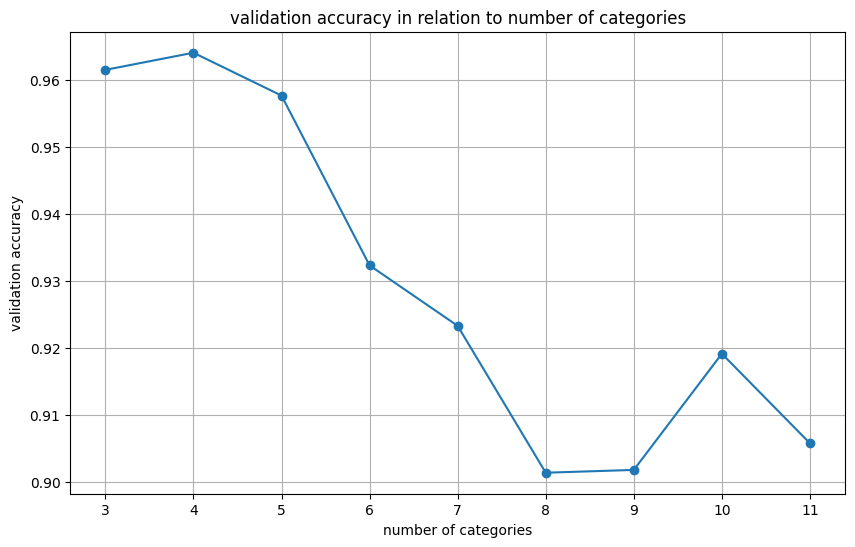

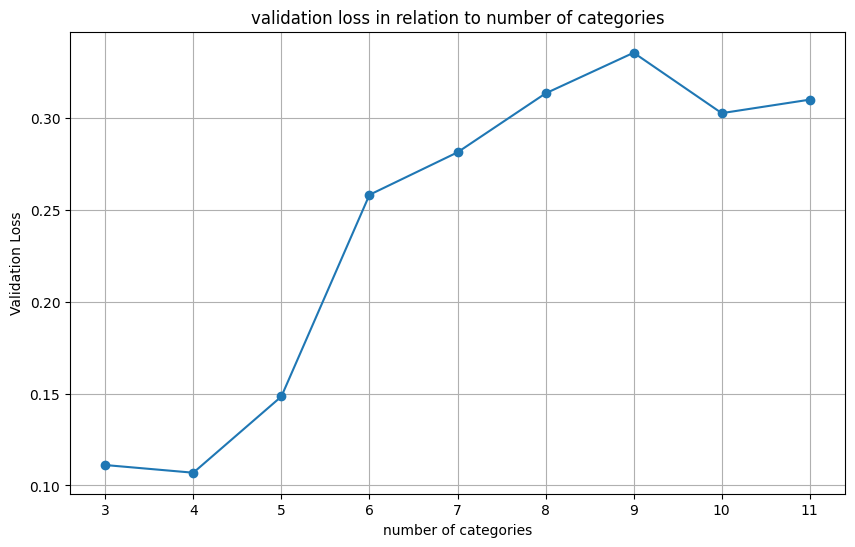

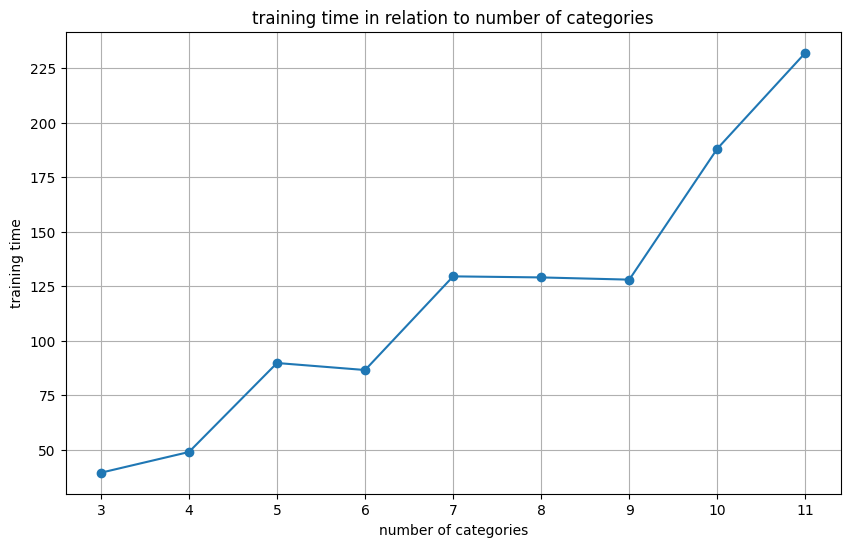

In [29]:
# chatGPT promt for visualization
val_loss = [i[0] for i in eval_array]
val_accuracy = [i[1] for i in eval_array]
num_classes = [i[2] for i in eval_array]
training_time = [i[3] for i in eval_array]


# val_acc
plt.figure(figsize=(10, 6))
plt.plot(num_classes, val_accuracy, marker='o')
plt.xlabel('number of categories')
plt.ylabel('validation accuracy')
plt.title('validation accuracy in relation to number of categories')
plt.grid(True)
plt.show()

# val_loss
plt.figure(figsize=(10, 6))
plt.plot(num_classes, val_loss, marker='o')
plt.xlabel('number of categories')
plt.ylabel('Validation Loss')
plt.title('validation loss in relation to number of categories')
plt.grid(True)
plt.show()

# training_time 
plt.figure(figsize=(10, 6))
plt.plot(num_classes, training_time, marker='o')
plt.xlabel('number of categories')
plt.ylabel('training time')
plt.title('training time in relation to number of categories')
plt.grid(True)
plt.show()

# Findings

## More categories result in:
- longer training duration
- higher loss
- lower accuracy

In [30]:
predict_durations

[[0.10801386833190918, 3],
 [0.08014869689941406, 4],
 [0.0805962085723877, 5],
 [0.08101892471313477, 6],
 [0.079376220703125, 7],
 [0.08101844787597656, 8],
 [0.08602142333984375, 9],
 [0.07954955101013184, 10],
 [0.09205389022827148, 11]]

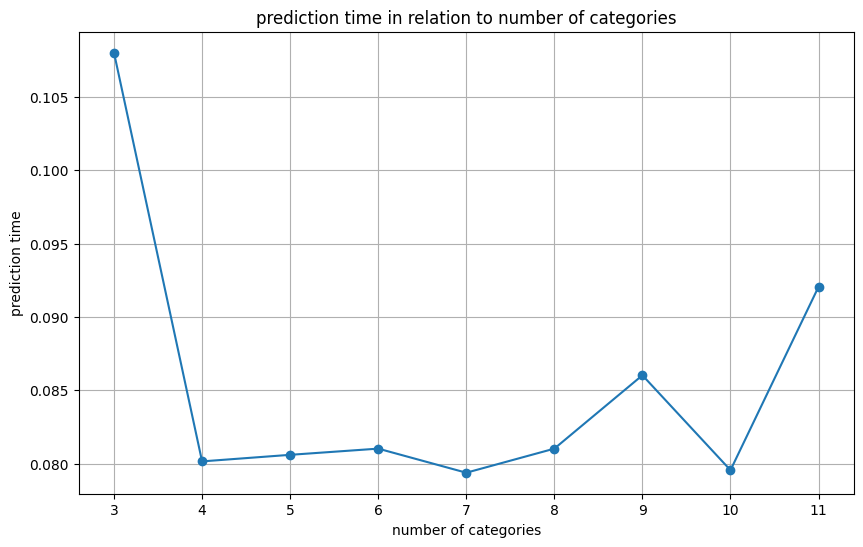

In [31]:
num_classes_pred = [i[1] for i in predict_durations]
prediction_time = [i[0] for i in predict_durations]

plt.figure(figsize=(10, 6))
plt.plot(num_classes_pred, prediction_time, marker='o')
plt.xlabel('number of categories')
plt.ylabel('prediction time')
plt.title('prediction time in relation to number of categories')
plt.grid(True)
plt.show()

# Findings

## More categories result in:
- prediction seems to take the same time for one sample at least
- longer duration for 8+ categories